# Chat Bot for an eCommerce Website

### Cadillac Lyriq - GM's All-Electric EV related conversational eCommerce chat bot

###### This is just a school project to demonstrate a chat bot which can be used in eCommerce to get some information about a vehicle.

#### Imports

In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer

#### Functions

In [2]:
def tokenize_into_words(sentence):
    return nltk.word_tokenize(sentence)

In [3]:
reducer = PorterStemmer()
def reduce(word):
    return reducer.stem(word.lower())

In [4]:
def bag_of_words(tokenized_sentence, words):
    words_in_sentences = [reduce(word) for word in tokenized_sentence]
    bag_of_words = np.zeros(len(words), dtype=np.float32)
    for index, word in enumerate(words):
        if word in words_in_sentences: 
            bag_of_words[index] = 1
    return bag_of_words

#### Reading from the data source (in JSON format)

In [5]:
file = open('lyriq-data.json')
vehicle = json.load(file)
file.close()

In [6]:
# See the JSON content
# vehicle['vehicleConfigurations']

#### Classes

In [7]:
class Neural_Network(nn.Module):
    def __init__(self, n_input, n_output ,n_hidden):
        super(Neural_Network, self).__init__()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(n_input, n_hidden) 
        self.l2 = nn.Linear(n_hidden, n_hidden) 
        self.l3 = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        o = self.l1(x)
        o = self.relu(o)
        o = self.l2(o)
        o = self.relu(o)
        o = self.l3(o)
        return o

In [8]:
class ChatBot_Dataset(Dataset):
    def __init__(self):
        self.x_data = x_training
        self.y_data = y_training
        self.n_samples = len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

#### Decorating Data for the Model

In [9]:
complete_words_list = []
types = []
product = []
for config in vehicle['vehicleConfigurations']:
    type_ = config['type']
    types.append(type_)
    for question in config['questions']:
        tokenized_words = tokenize_into_words(question)
        complete_words_list.extend(tokenized_words)
        product.append((tokenized_words, type_))
        
characters_to_ignore = [',', '/','&', '!', '.', '(', ')', '-', '?']
complete_words_list = [reduce(word) for word in complete_words_list if word not in characters_to_ignore]

complete_words_list = sorted(set(complete_words_list))
types = sorted(set(types))

#### Getting Started with Training

In [10]:
x_training = []
y_training = []

for (sentence, type_) in product:
    bag_with_words = bag_of_words(sentence, complete_words_list)
    x_training.append(bag_with_words)
    output_label = types.index(type_)
    y_training.append(output_label)

x_training = np.array(x_training)
y_training = np.array(y_training)

#### Setting up Model/ Training configuration

In [11]:
number_of_epochs = 7000
batch_size = 8
n_hidden = 8
learning_rate = 0.01
n_input = len(x_training[0])
n_output = len(types)

104 11


#### PyTorch Training Implementation

In [12]:
chatbot_dataset = ChatBot_Dataset()
device = torch.device('cpu')
model = Neural_Network(n_input, n_output, n_hidden).to(device)
criteria = nn.CrossEntropyLoss()

loss_array = []
for epoch in range(number_of_epochs):
    for (features, responses) in DataLoader(dataset = chatbot_dataset, 
                                            batch_size = batch_size, 
                                            shuffle = False, 
                                            num_workers = 0):
        features = features.to(device)
        responses = responses.to(dtype = torch.long).to(device)
        responses2 = model(features)
        loss = criteria(responses2, responses)
        torch.optim.SGD(model.parameters(), lr = learning_rate).zero_grad()
        loss.backward()
        torch.optim.SGD(model.parameters(), lr = learning_rate).step()
        
    if (epoch) % 100 == 0:
        loss_value = loss.item()
        loss_array.append(loss_value)
    if (epoch) % 500 == 0:
        print (f'Epoch: {epoch}/{number_of_epochs} Loss: {loss_value}')

vehicle_data = {
"model": model.state_dict(),
"n_hidden": n_hidden,
"complete_words_list": complete_words_list,
"types": types,
"n_input": n_input,
"n_output": n_output
}

torch.save(vehicle_data, "vehicle_data.pth")
print(f'Training is complete.')

Epoch: 0/7000 Loss: 2.3653626441955566
Epoch: 500/7000 Loss: 0.8441026210784912
Epoch: 1000/7000 Loss: 0.14575713872909546
Epoch: 1500/7000 Loss: 0.023494645953178406
Epoch: 2000/7000 Loss: 0.008916274644434452
Epoch: 2500/7000 Loss: 0.0050338925793766975
Epoch: 3000/7000 Loss: 0.003395514329895377
Epoch: 3500/7000 Loss: 0.002521499292925
Epoch: 4000/7000 Loss: 0.0019842851907014847
Epoch: 4500/7000 Loss: 0.0016252989880740643
Epoch: 5000/7000 Loss: 0.0013699035625904799
Epoch: 5500/7000 Loss: 0.0011796940816566348
Epoch: 6000/7000 Loss: 0.0010331124067306519
Epoch: 6500/7000 Loss: 0.000918084173463285
Training is complete.


Finally the loss is: 0.000825


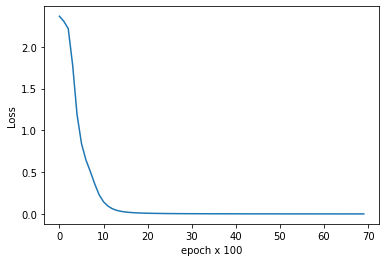

In [13]:
print(f'Finally the loss is: {loss.item():.6f}')
plt.plot(loss_array)
plt.ylabel('Loss')
plt.xlabel('epoch x 100')
plt.show()

#### Chat Bot Interface

In [14]:
file_name_from_training = "vehicle_data.pth"
data = torch.load(file_name_from_training)

model = data["model"]
n_hidden = data["n_hidden"]
complete_words_list = data['complete_words_list']
types = data['types']
n_input = data["n_input"]
n_output = data["n_output"]

nn_model = Neural_Network(n_input, n_output, n_hidden).to(device)
nn_model.load_state_dict(model)
nn_model.eval()

print("Welcome to Saad's ChatBot! (type 'quit' to exit)")
print("Please ask me any questions related to Cadillac's All Electric new EV!")

exit_tokens = ['thanks', 'thank you', 'bye', 'exit']
print(f"Type in {exit_tokens} to close the chatbot!")

sentence = input("Your Question: ")
while sentence not in exit_tokens:
    sentence = tokenize_into_words(sentence)
    _input = bag_of_words(sentence, complete_words_list)
    _input = _input.reshape(1, _input.shape[0])
    _input = torch.from_numpy(_input).to(device)

    _output = nn_model(_input)
    _, predicted = torch.max(_output, dim=1)

    type_ = types[predicted.item()]

    probs = torch.softmax(_output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() >= 0.75:
        for config in vehicle['vehicleConfigurations']:
            if type_ == config["type"]:
                print(f"GM Assistant:  {config['answer']}")
    elif prob.item() >= 0.5:
        for config in vehicle['vehicleConfigurations']:
            if type_ == config["type"]:
                print(f"GM Assistant:  Maybe you're asking that: {config['answer']}")
    else:
        print(f"GM Assistant:  Sorry, I do not know what you're asking. Please contact the GM representative for this.")
    print()
        
    sentence = input("Your Question: ")
print("Thank you for your interest in knowing this vehicle and using the GM Chatbot assistant. Have a great day!")

Welcome to Saad's ChatBot! (type 'quit' to exit)
Please ask me any questions related to Cadillac's All Electric new EV!
Type in ['thanks', 'thank you', 'bye', 'exit'] to close the chatbot!
Your Question: What is the total system output?
GM Assistant:  It has a single permanent motor producing 325 lb.-ft of torque (equivalent to 440Nm).

Your Question: How fast is 0 to 60?
GM Assistant:  Its instant acceleration can bring 0 to 60 MPH in about 3 seconds.

Your Question: How many people can be seated?
GM Assistant:  The seating capacity is 5 passengers.

Your Question: how fast does it accelerate?
GM Assistant:  Its instant acceleration can bring 0 to 60 MPH in about 3 seconds.

Your Question: How much is the battery capacity?
GM Assistant:  The total capacity of the battery pack is 100kWh.

Your Question: Does it has AWD?
GM Assistant:  Currently, it comes only in the RWD (Rear Wheel Drive) configuration/ drivetrain.

Your Question: Which body styles are available?
GM Assistant:  It is a